# Amyloid & prion protein classification

Based upon code & knowledge outlined at https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

## Preprocess
### Parse FASTA into CSV
The PLAAC dataset is in FASTA format, which will be parsed into a CSV table for preprocessing. We'll record the gene name, Uniprot sequence range & sequence text, and add positive prion & amyloid classifications.

In [56]:
import sys, os

plaacFasta = 'positiveExamples/yeastPrion.fasta'
negativeFasta = 'negativeExamples/negative.fasta'
positiveDataset = 'positiveExamples/positiveDataset.csv'
negativeDataset = 'negativeExamples/negativeDataset.csv'
destination_folder = "./output"

def fastaToCSV(fastaPath, csvPath, prionClassification = 0, amyloidClassification = 0):
    # Read in FASTA
    with open(fastaPath, 'r') as file:
        lines = ["header,sequence,prion,amyloid"]
        lines_i = file.readlines()

        seq = ''
        index = 0
        while index < len(lines_i):
            if lines_i[index][0] == '>':
                'Fasta head line'
                # append sequence & prion classification
                if seq: lines.append(seq + ',' + str(prionClassification) + ',' + str(amyloidClassification))
                seq = ''
                # remove FASTA syntactic sugar
                seq_id = lines_i[index].strip().replace(',', '').replace('>', '')
                # remove uniprot metadata using pipe & equal sign delimiter
                seq_id = " ".join((seq_id.split(" "))[1:]) if "|" in seq_id else seq_id
                lastHeaderIndex = seq_id.index("=") - 3 if ('=' in seq_id) else len(seq_id)
                lines.append('\n' + seq_id[:lastHeaderIndex] + ',')
            else:
                'Sequence line'
                seq += lines_i[index].strip()
                if (index == len(lines_i) - 1): lines.append(seq + ',' + str(prionClassification) + ',' + str(amyloidClassification))
            index += 1
        lines.append("\n")
        file.close()

    # Output CSV file
    with open(csvPath, 'w') as file:
        file.writelines(lines)
        file.close()
    return

# negative
fastaToCSV(negativeFasta, negativeDataset)
# PLAAC prions
fastaToCSV(plaacFasta, positiveDataset, 1, 1)


### Parse JSON into CSV
The Amypro dataset is in JSON format, so we'll use JSON tools to parse data into a CSV table of the same format as above. 

In [57]:
import json 
import csv 

amyproDataset = 'positiveExamples/amyproAmyloids.json'

with open(amyproDataset, encoding = 'utf-8-sig') as json_file: 
    data = json.load(json_file) 
    lines = []
    for amyloid in data:
        lines.append(amyloid["protein_name"].replace(',', '') + (' [' + amyloid["uniprot_start"] + '-' + amyloid["uniprot_end"] + ']' if amyloid["uniprot_start"] != "" else "")+ ',')
        lines.append(amyloid["sequence"] + ',')
        lines.append(str(amyloid["prion_domain"]) + ',')
        # positive amyloid classification
        lines.append('1' + '\n')
    json_file.close()

# Append to CSV file
with open(positiveDataset, 'a') as file:
    file.writelines(lines)
    file.close()

### Read CSVs into a Panda dataframe to generate training, testing & validation datasets
For performance reasons, header names are replaced with indexes that reference an in-memory dictionary. A constant random seed may be assigned to ensure the same data is split across training, testing & validation.

In [67]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split, KFold

train_validation_ratio = 0.7
train_test_ratio = 0.7
df_train, df_test = pd.DataFrame(), pd.DataFrame()

def generateDataFrames(randomSeed):
    # Read raw data & combine 
    df_positive = pd.read_csv(positiveDataset).applymap(lambda x: x.strip() if type(x)==str else x)
    df_negative = pd.read_csv(negativeDataset).applymap(lambda x: x.strip() if type(x)==str else x)
    df_full = pd.concat([df_positive, df_negative], ignore_index=True)

    # Generate in-memory index for headers & compress dataframe
    datasetIndex = {}
    for index in range(len(df_full.index)):
        datasetIndex[index] = df_full.at[index, 'header']
        df_full.at[index, 'header'] = index

    # Split amyloid class
    df_notAmyloid = df_full[df_full['amyloid'] == 0]
    df_amyloid = df_full[df_full['amyloid'] == 1]

    # Train-validation split
    df_amyloid_trainSuperset, df_amyloid_validation = train_test_split(df_amyloid, train_size = train_validation_ratio, random_state = randomSeed)
    df_notAmyloid_trainSuperset, df_notAmyloid_validation  = train_test_split(df_notAmyloid, train_size = train_validation_ratio, random_state = randomSeed)

    # Train-test split
    df_amyloid_train, df_amyloid_test = train_test_split(df_amyloid_trainSuperset, train_size = train_test_ratio, random_state = randomSeed)
    df_notAmyloid_train, df_notAmyloid_test = train_test_split(df_notAmyloid_trainSuperset, train_size = train_test_ratio, random_state = randomSeed)

    # Concatenate splits of different labels into training, testing & validation sets
    df_train = pd.concat([df_amyloid_train, df_notAmyloid_train], ignore_index=True, sort=False)
    df_test = pd.concat([df_amyloid_test, df_notAmyloid_test], ignore_index=True, sort=False)
    df_valid = pd.concat([df_amyloid_validation, df_notAmyloid_validation], ignore_index=True, sort=False)
    df_full = pd.concat([df_train, df_test], ignore_index=True, sort=False)

    # Write preprocessed data
    df_train.to_csv('train.csv', index=False)
    df_test.to_csv('test.csv', index=False)
    df_valid.to_csv('valid.csv', index=False)
    df_full.to_csv('full.csv', index=False)

    return datasetIndex



## Implement the model
### Import necessary libraries

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# set processing device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# data 

from torchtext.legacy.data import Field, TabularDataset, BucketIterator
from torch.utils.data import ConcatDataset

# model

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# training

import torch.optim as optim

# evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns

### Load data


In [69]:
# Tokenize peptide sequences by splitting into individual amino acids
def split(sequence):
    return [char for char in sequence] 

def declareFields():
    header = Field(sequential=False, dtype=torch.int, use_vocab=False, include_lengths=False)
    sequence = Field(tokenize=split, sequential=True, include_lengths=True, batch_first=True)
    amyloidLabel = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float, include_lengths=False)
    prionLabel = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float, include_lengths=False)

    fields = [('header', header), ('sequence', sequence), ('prion', prionLabel), ('amyloid', amyloidLabel)]
    # Create TabularDatasets for vocab & fold splits
    train, test = TabularDataset.splits(path="./", train="train.csv", test="test.csv", format='CSV', fields=fields, skip_header=True)
    full = ConcatDataset([train, test])

    # Vocabulary
    sequence.build_vocab(train)
    print("Vocabulary: " + str(sequence.vocab.stoi.items()))

    return full, fields, sequence

randomSeed = int(abs(np.random.normal() * 10))
datasetIndex = generateDataFrames(randomSeed)
fullDataset, fields, sequence = declareFields()
  

Vocabulary: dict_items([('<unk>', 0), ('<pad>', 1), ('L', 2), ('S', 3), ('A', 4), ('E', 5), ('T', 6), ('G', 7), ('V', 8), ('K', 9), ('N', 10), ('D', 11), ('P', 12), ('Q', 13), ('I', 14), ('R', 15), ('F', 16), ('Y', 17), ('H', 18), ('M', 19), ('C', 20), ('W', 21)])


### Model
A stacked, bidirectional gated recurrent unit (GRU) network will be applied to learn amyloidogenic & prionogenic relations in peptide sequences. 

This network is composed of an embedding layer to vectorize input sequences, two GRU layers, and a fully-connected linear output layer gated by sigmoidal activation.

Hyperparameters:
- embedding & hidden layer dimensions
- depth of LSTM 
- LSTM bidirectionality
- neuron dropout probability

In [61]:
class GRU(nn.Module):

    def __init__(self, vocab, dimension=128):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(len(vocab), 64)
        self.dimension = dimension
        self.GRU = nn.GRU(input_size=64,
                            hidden_size=dimension,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True,
                            dropout=0.3)
        self.dropOutput = nn.Dropout(p=0.3)

        # output layer
        self.fc = nn.Linear(2 * dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.GRU(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.dropOutput(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

#### Second model
A similar, but less performant, long-short term memory model is supplied here.

In [62]:
class LSTM(nn.Module):

    def __init__(self, vocab, dimension=64):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(vocab), 32)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=32,
                            hidden_size=dimension,
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True,
                            dropout=0.5)
        self.dropOnOutput = nn.Dropout(p=0.5)

        # output layer
        self.fc = nn.Linear(2 * dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.dropOnOutput(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

## Train
### Functions to collect evaluation metrics & model state during training

In [63]:
def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

### Training function
#### CSV helper

In [64]:
def sampleCSV(csvFilePath, sampleType, sampler):
    df_full = pd.read_csv(csvFilePath)
    df_sample = df_full.iloc[sampler]
    df_sample.to_csv(destination_folder + '/sample' + sampleType + '.csv', index=False)
    return 'sample' + sampleType + '.csv'


In [65]:
def train(vocab,
          lr,
          criterion,
          dataset,
          fields,
          foldCount,
          file_path,
          num_epochs = 5,
          amyloid = True,
          best_valid_loss = float("inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = {i:[] for i in range(foldCount)}
    valid_loss_list = {i:[] for i in range(foldCount)}
    global_steps_list = {i:[] for i in range(foldCount)}

    # K-fold cross-validation loop

    kfold = KFold(n_splits=foldCount, shuffle=True)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        print(f'FOLD {fold+1}')
        print('--------------------------------')

        # sample elements in list of IDs
        # train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        # test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        trainSamplePath = sampleCSV('full.csv', 'Train' + str(fold), train_ids)
        testSamplePath = sampleCSV('full.csv', 'Test' + str(fold), test_ids)

        # create datasets for current fold
         # Create TabularDatasets
        trainData, testData = TabularDataset.splits(path="./", train="output/sampleTrain" + str(fold) + ".csv", test="output/sampleTest" + str(fold) + ".csv", format='CSV', fields=fields, skip_header=True)

        # create iterators for current fold
            # sort by sequence length to keep batches consistent 
        train_iter =  BucketIterator(trainData, batch_size=16, sort_key=lambda x: len(x.sequence),
                            device=device, sort=True, sort_within_batch=True)
        test_iter =  BucketIterator(testData, batch_size=16, sort_key=lambda x: len(x.sequence),
                            device=device, sort=True, sort_within_batch=True)
        eval_every=len(train_iter) // 2

        # initialize model
        model = GRU(vocab=vocab).to(device)

        # load optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr)


        # training loop
        model.train()
        for epoch in range(num_epochs):
            for (header, (sequence, sequence_len), prionLabel, amyloidLabel), _ in train_iter:           
                prionLabel = prionLabel.to(device)
                amyloidLabel = amyloidLabel.to(device)
                sequence = sequence.to(device)
                sequence_len = sequence_len.to(device)
                output = model(sequence, sequence_len.cpu())

                amyloidLoss = criterion(output, amyloidLabel)
                prionLoss = criterion(output, prionLabel)
                loss = amyloidLoss if amyloid else prionLoss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # update running values
                running_loss += loss.item()
                global_step += 1
                
                # Evaluation for this fold
                if global_step % eval_every == 0:
                    model.eval()
                    with torch.no_grad():                    
                        # validation loop
                        for (header, (sequence, sequence_len), prionLabel, amyloidLabel), _ in test_iter:   
                            prionLabel = prionLabel.to(device)
                            amyloidLabel = amyloidLabel.to(device)
                            sequence = sequence.to(device)
                            sequence_len = sequence_len.to(device)
                            output = model(sequence, sequence_len.cpu())
                            
                            amyloidLoss = criterion(output, amyloidLabel)
                            prionLoss = criterion(output, prionLabel)
                            loss = amyloidLoss if amyloid else prionLoss
                            valid_running_loss += loss.item()
                
                    # record loss
                    average_train_loss = running_loss / eval_every
                    average_valid_loss = valid_running_loss / len(test_iter)
                    train_loss_list[fold].append(average_train_loss)
                    valid_loss_list[fold].append(average_valid_loss)
                    global_steps_list[fold].append(global_step)

                    # resetting running values
                    valid_running_loss = 0.0
                    running_loss = 0.0
                    model.train()

                    # print progress
                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                            .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter)*(foldCount)*(foldCount),
                                    average_train_loss, average_valid_loss))
                    
                    save_metrics(file_path + f'/metrics{fold}.pt', train_loss_list[fold], valid_loss_list[fold], global_steps_list[fold])
                    torch.save(model, destination_folder + f'/model{fold}.pt')
                    

    print('Finished Training!')
    return train_loss_list, valid_loss_list, global_steps_list

### Entry point for training amyloid-only model

Hyperparameters:
 - Learning rate
 - Epoch count
 - Loss function
 - Optimizer


In [140]:
training_losses, validation_losses, global_steps = train(vocab=sequence.vocab, lr=0.00025, criterion=nn.SmoothL1Loss(), fields=fields, dataset=fullDataset, foldCount=10, file_path = destination_folder, num_epochs=8)

FOLD 0
--------------------------------
Epoch [1/8], Step [7/12000], Train Loss: 0.1234, Valid Loss: 0.1345
Model saved to ==> ./output/metrics0.pt
Epoch [1/8], Step [14/12000], Train Loss: 0.1288, Valid Loss: 0.1213
Model saved to ==> ./output/metrics0.pt
Epoch [2/8], Step [21/12000], Train Loss: 0.1032, Valid Loss: 0.1095
Model saved to ==> ./output/metrics0.pt
Epoch [2/8], Step [28/12000], Train Loss: 0.0999, Valid Loss: 0.0988
Model saved to ==> ./output/metrics0.pt
Epoch [3/8], Step [35/12000], Train Loss: 0.0858, Valid Loss: 0.0881
Model saved to ==> ./output/metrics0.pt
Epoch [3/8], Step [42/12000], Train Loss: 0.0801, Valid Loss: 0.0824
Model saved to ==> ./output/metrics0.pt
Epoch [4/8], Step [49/12000], Train Loss: 0.0750, Valid Loss: 0.0754
Model saved to ==> ./output/metrics0.pt
Epoch [4/8], Step [56/12000], Train Loss: 0.0676, Valid Loss: 0.0738
Model saved to ==> ./output/metrics0.pt
Epoch [5/8], Step [63/12000], Train Loss: 0.0653, Valid Loss: 0.0696
Model saved to ==> .

## Evaluate


### Training losses

Model loaded from <== ./output/metrics0.pt
Model loaded from <== ./output/metrics1.pt
Model loaded from <== ./output/metrics2.pt
Model loaded from <== ./output/metrics3.pt
Model loaded from <== ./output/metrics4.pt
Model loaded from <== ./output/metrics5.pt
Model loaded from <== ./output/metrics6.pt
Model loaded from <== ./output/metrics7.pt
Model loaded from <== ./output/metrics8.pt
Model loaded from <== ./output/metrics9.pt


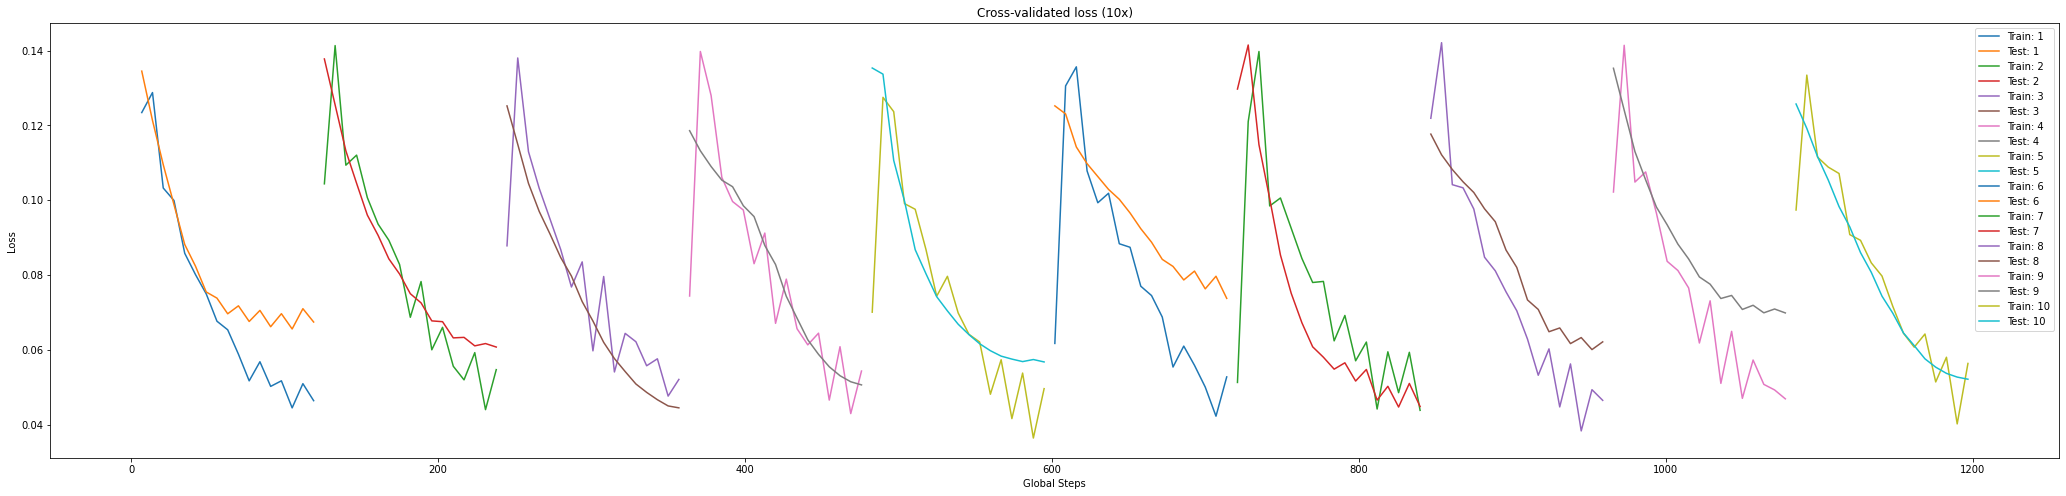

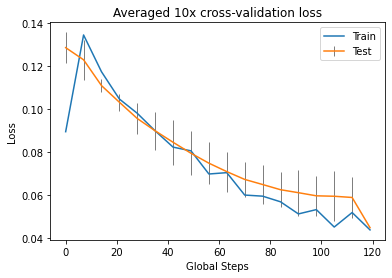

In [141]:
foldCount = 10
if len(global_steps[0]) != len(train_loss_list): global_steps[0].insert(0, 0) 

# average losses 
totalTrainingLosses = pd.DataFrame(list(training_losses.values()))
totalTestingLosses = pd.DataFrame(list(validation_losses.values()))
totalTrainingLosses.to_csv(destination_folder + '/averageTrainingLosses.csv')
totalTestingLosses.to_csv(destination_folder + '/averageTestingLosses.csv')

averageTrainingLosses = totalTrainingLosses.mean(axis=0)
averageTrainingDeviation = totalTrainingLosses.std(axis=0)
averageTestingLosses= totalTestingLosses.mean(axis=0)
averageTestingDeviation = totalTestingLosses.std(axis=0)

# plot loss across folds
plt.figure(figsize=(36,8))
plt.title('Cross-validated loss (10x)')
for fold in range(foldCount):
    train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + f'/metrics{fold}.pt')
    plt.plot(global_steps_list, train_loss_list, label=f'Train: {fold+1}')
    plt.plot(global_steps_list, valid_loss_list, label=f'Test: {fold+1}')
    plt.legend()
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.show()

# plot average loss across folds
plt.title('Averaged 10x cross-validation loss')
plt.plot(global_steps[0], averageTrainingLosses, label='Train')
plt.errorbar(global_steps[0], averageTestingLosses, averageTestingDeviation, label='Test', ecolor='black', elinewidth=0.5)
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

### Confusion matrix, heuristics & external validation

In [142]:
def kFoldEvaluate(model, foldCount, csvDatasetPath = None, threshold=.6):
    y_pred = []
    y_true = []

    def evaluate(dataPath, y_pred, y_true):
        testData = TabularDataset(path=dataPath, format="CSV", fields=fields, skip_header=True)
        test_iter =  BucketIterator(testData, batch_size=16, sort_key=lambda x: len(x.sequence),
                                device=device, sort=True, sort_within_batch=True)
        with torch.no_grad():
            for (header, (sequence, sequence_len), prionLabel, amyloidLabel), _ in test_iter:           
                prionLabel = prionLabel.to(device)
                amyloidLabel = amyloidLabel.to(device)
                sequence = sequence.to(device)
                sequence_len = sequence_len.to(device)
                output = model(sequence, sequence_len.cpu())

                output = (output > threshold).int()
                y_pred.extend(output.tolist())
                y_true.extend(amyloidLabel.tolist())

    model.eval()
    if not csvDatasetPath:
        for fold in range(foldCount):
            evaluate(destination_folder + "/sampleTest" + str(fold) + ".csv", y_pred, y_true)
    else:
        evaluate(csvDatasetPath, y_pred, y_true)
            
    return y_pred, y_true


### Classification report, confusion matrix & ROC

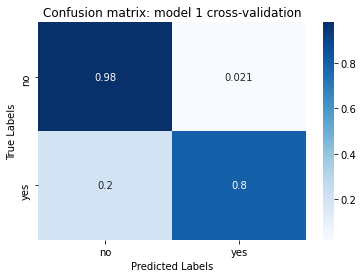

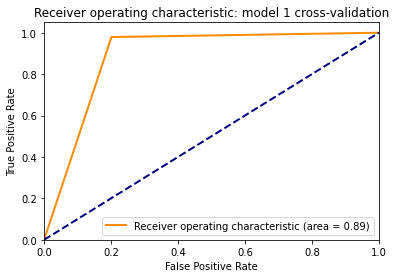

Classification Report
              precision    recall  f1-score   support

           1     0.7520    0.9792    0.8507        96
           0     0.9840    0.7987    0.8817       154

    accuracy                         0.8680       250
   macro avg     0.8680    0.8889    0.8662       250
weighted avg     0.8949    0.8680    0.8698       250



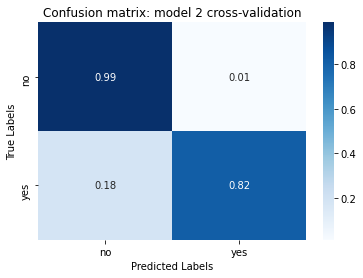

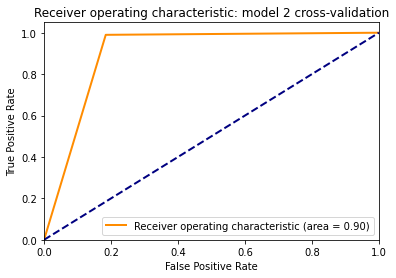

Classification Report 2:
              precision    recall  f1-score   support

           1     0.7760    0.9898    0.8700        98
           0     0.9920    0.8158    0.8953       152

    accuracy                         0.8840       250
   macro avg     0.8840    0.9028    0.8826       250
weighted avg     0.9073    0.8840    0.8854       250



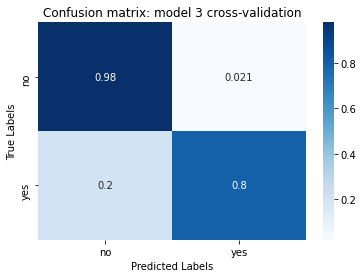

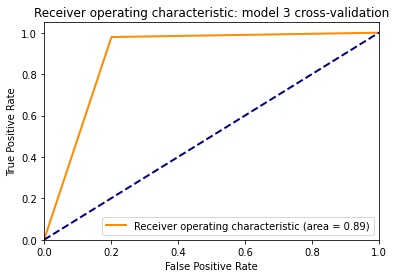

Classification Report 3:
              precision    recall  f1-score   support

           1     0.7520    0.9792    0.8507        96
           0     0.9840    0.7987    0.8817       154

    accuracy                         0.8680       250
   macro avg     0.8680    0.8889    0.8662       250
weighted avg     0.8949    0.8680    0.8698       250



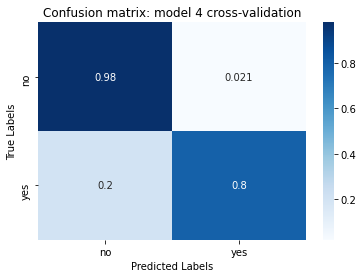

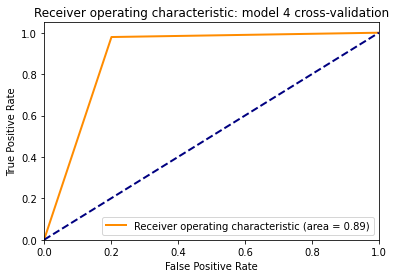

Classification Report 4:
              precision    recall  f1-score   support

           1     0.7520    0.9792    0.8507        96
           0     0.9840    0.7987    0.8817       154

    accuracy                         0.8680       250
   macro avg     0.8680    0.8889    0.8662       250
weighted avg     0.8949    0.8680    0.8698       250



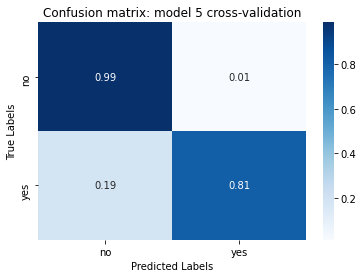

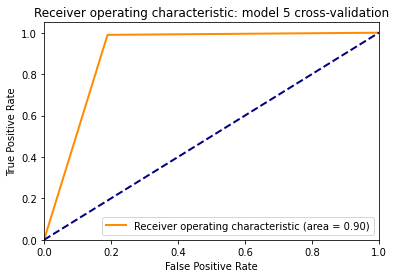

Classification Report 5:
              precision    recall  f1-score   support

           1     0.7680    0.9897    0.8649        97
           0     0.9920    0.8105    0.8921       153

    accuracy                         0.8800       250
   macro avg     0.8800    0.9001    0.8785       250
weighted avg     0.9051    0.8800    0.8815       250



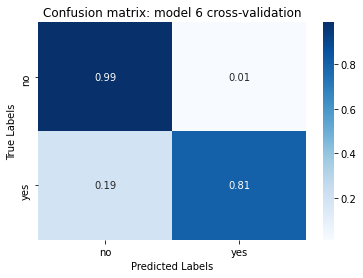

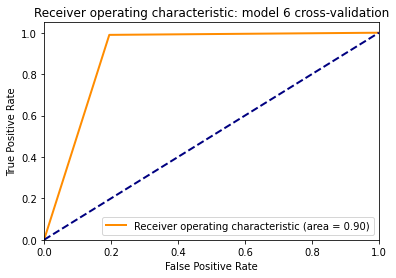

Classification Report 6:
              precision    recall  f1-score   support

           1     0.7600    0.9896    0.8597        96
           0     0.9920    0.8052    0.8889       154

    accuracy                         0.8760       250
   macro avg     0.8760    0.8974    0.8743       250
weighted avg     0.9029    0.8760    0.8777       250



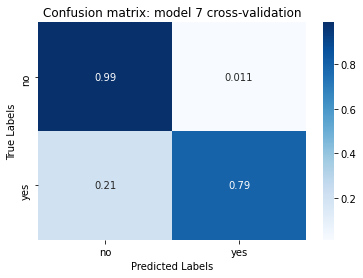

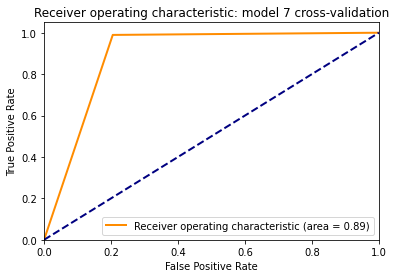

Classification Report 7:
              precision    recall  f1-score   support

           1     0.7440    0.9894    0.8493        94
           0     0.9920    0.7949    0.8826       156

    accuracy                         0.8680       250
   macro avg     0.8680    0.8921    0.8659       250
weighted avg     0.8988    0.8680    0.8701       250



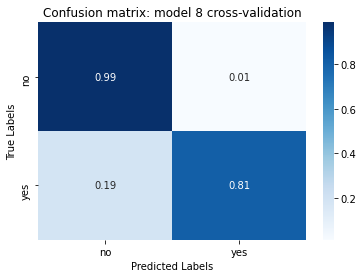

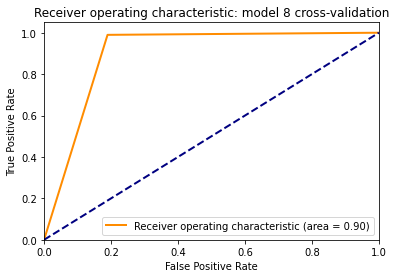

Classification Report 8:
              precision    recall  f1-score   support

           1     0.7680    0.9897    0.8649        97
           0     0.9920    0.8105    0.8921       153

    accuracy                         0.8800       250
   macro avg     0.8800    0.9001    0.8785       250
weighted avg     0.9051    0.8800    0.8815       250



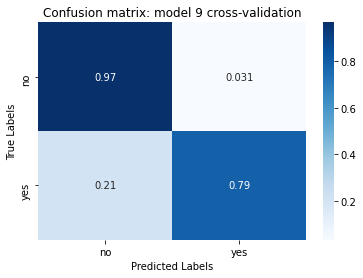

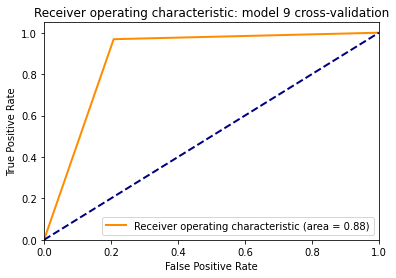

Classification Report 9:
              precision    recall  f1-score   support

           1     0.7440    0.9688    0.8416        96
           0     0.9760    0.7922    0.8746       154

    accuracy                         0.8600       250
   macro avg     0.8600    0.8805    0.8581       250
weighted avg     0.8869    0.8600    0.8619       250



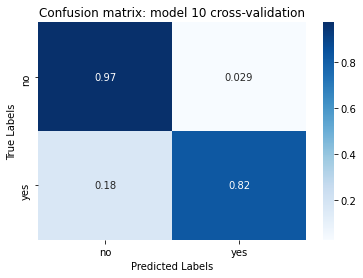

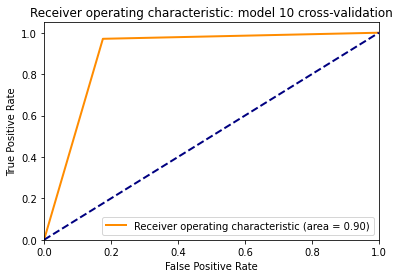

Classification Report 10:
              precision    recall  f1-score   support

           1     0.7920    0.9706    0.8722       102
           0     0.9760    0.8243    0.8938       148

    accuracy                         0.8840       250
   macro avg     0.8840    0.8975    0.8830       250
weighted avg     0.9009    0.8840    0.8850       250

bestROC: 0.9027926960257787, fold 2


In [143]:
def getHeuristics(y_true, y_pred, confusionMatrixTitle, ROCtitle, fold=None):
    cm = confusion_matrix(y_true, y_pred, labels=[1,0], normalize='true')
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues')

    ax.set_title(confusionMatrixTitle)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['no', 'yes'])
    ax.yaxis.set_ticklabels(['no', 'yes'])


    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label=f'Receiver operating characteristic (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(ROCtitle)
    plt.legend(loc="lower right")
    plt.show()

    print(f'Classification Report {fold + 1}:' if fold else 'Classification Report')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    return roc_auc

y_pred, y_true = dict(), dict()
bestModel = { 'model': None, 'fold': 0}
bestROC = 0
for fold in range(foldCount):
    model = torch.load(destination_folder + f'/model{fold}.pt')
    y_pred[fold], y_true[fold] = kFoldEvaluate(model, foldCount)
    roc = getHeuristics(y_pred[fold], y_true[fold], f"Confusion matrix: model {fold + 1} cross-validation", f"Receiver operating characteristic: model {fold + 1} cross-validation", fold)
    if roc > bestROC: 
        bestROC = roc
        bestModel['model'], bestModel['fold'] = model, fold + 1
print("bestROC: " + str(bestROC) + ', fold ' + str(bestModel['fold']))



#### External validation

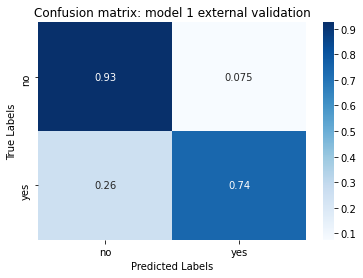

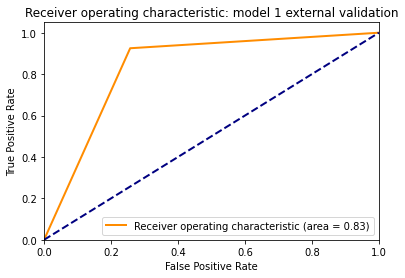

Classification Report
              precision    recall  f1-score   support

           1     0.6727    0.9250    0.7789        40
           0     0.9455    0.7429    0.8320        70

    accuracy                         0.8091       110
   macro avg     0.8091    0.8339    0.8055       110
weighted avg     0.8463    0.8091    0.8127       110



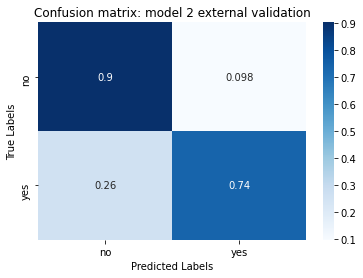

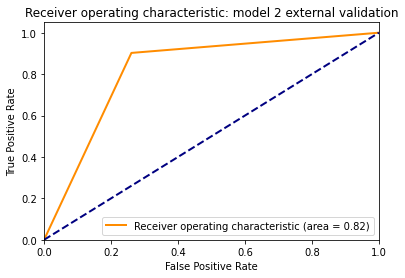

Classification Report 2:
              precision    recall  f1-score   support

           1     0.6727    0.9024    0.7708        41
           0     0.9273    0.7391    0.8226        69

    accuracy                         0.8000       110
   macro avg     0.8000    0.8208    0.7967       110
weighted avg     0.8324    0.8000    0.8033       110



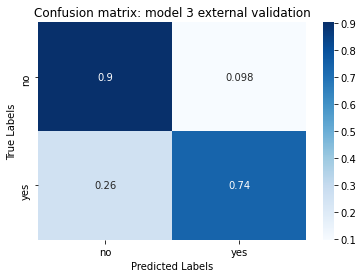

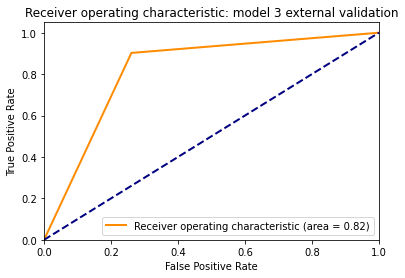

Classification Report 3:
              precision    recall  f1-score   support

           1     0.6727    0.9024    0.7708        41
           0     0.9273    0.7391    0.8226        69

    accuracy                         0.8000       110
   macro avg     0.8000    0.8208    0.7967       110
weighted avg     0.8324    0.8000    0.8033       110



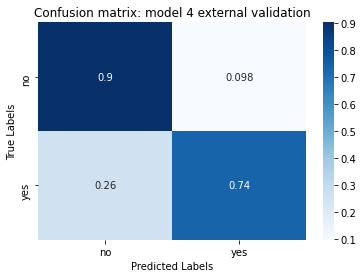

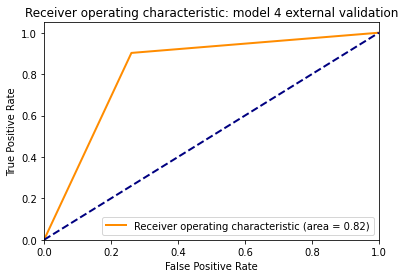

Classification Report 4:
              precision    recall  f1-score   support

           1     0.6727    0.9024    0.7708        41
           0     0.9273    0.7391    0.8226        69

    accuracy                         0.8000       110
   macro avg     0.8000    0.8208    0.7967       110
weighted avg     0.8324    0.8000    0.8033       110



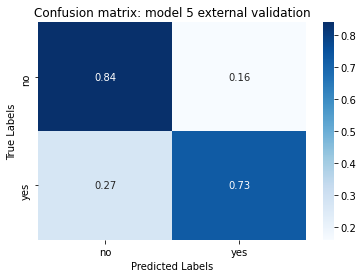

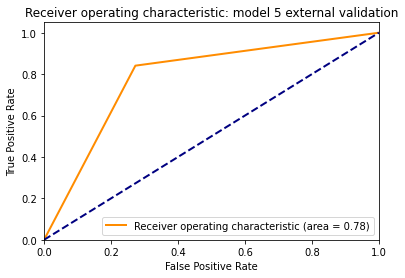

Classification Report 5:
              precision    recall  f1-score   support

           1     0.6727    0.8409    0.7475        44
           0     0.8727    0.7273    0.7934        66

    accuracy                         0.7727       110
   macro avg     0.7727    0.7841    0.7704       110
weighted avg     0.7927    0.7727    0.7750       110



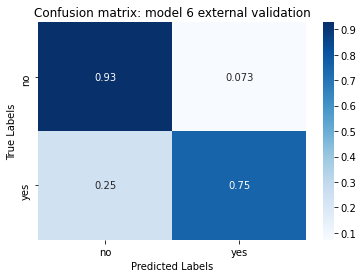

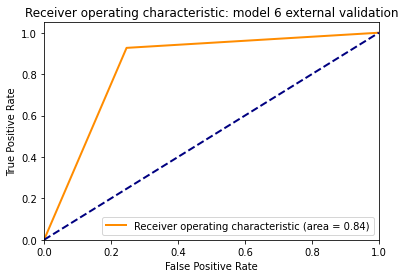

Classification Report 6:
              precision    recall  f1-score   support

           1     0.6909    0.9268    0.7917        41
           0     0.9455    0.7536    0.8387        69

    accuracy                         0.8182       110
   macro avg     0.8182    0.8402    0.8152       110
weighted avg     0.8506    0.8182    0.8212       110



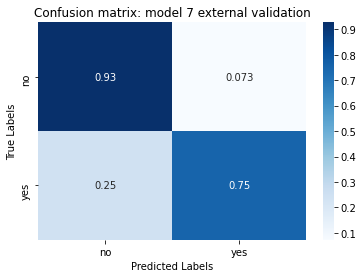

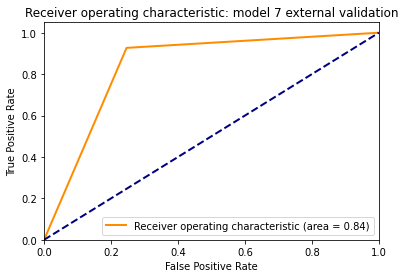

Classification Report 7:
              precision    recall  f1-score   support

           1     0.6909    0.9268    0.7917        41
           0     0.9455    0.7536    0.8387        69

    accuracy                         0.8182       110
   macro avg     0.8182    0.8402    0.8152       110
weighted avg     0.8506    0.8182    0.8212       110



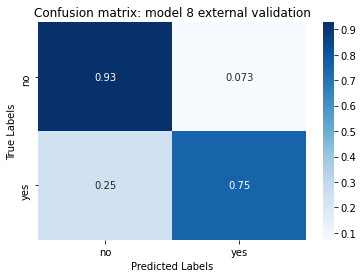

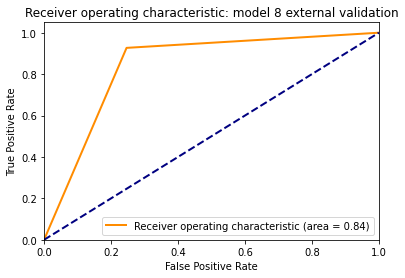

Classification Report 8:
              precision    recall  f1-score   support

           1     0.6909    0.9268    0.7917        41
           0     0.9455    0.7536    0.8387        69

    accuracy                         0.8182       110
   macro avg     0.8182    0.8402    0.8152       110
weighted avg     0.8506    0.8182    0.8212       110



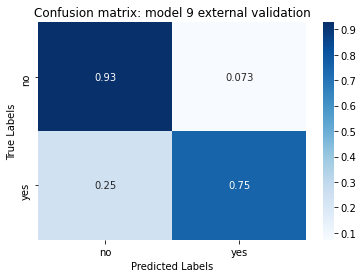

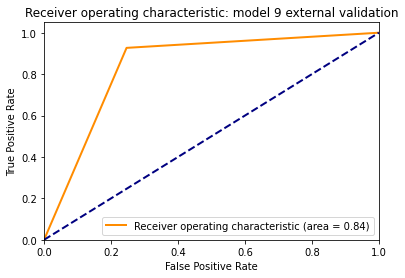

Classification Report 9:
              precision    recall  f1-score   support

           1     0.6909    0.9268    0.7917        41
           0     0.9455    0.7536    0.8387        69

    accuracy                         0.8182       110
   macro avg     0.8182    0.8402    0.8152       110
weighted avg     0.8506    0.8182    0.8212       110



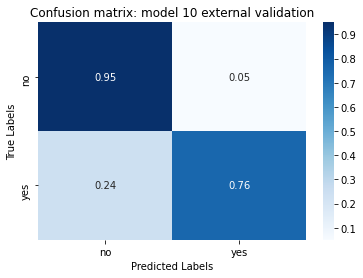

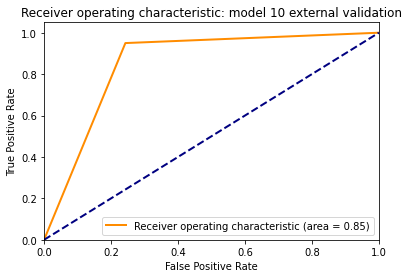

Classification Report 10:
              precision    recall  f1-score   support

           1     0.6909    0.9500    0.8000        40
           0     0.9636    0.7571    0.8480        70

    accuracy                         0.8273       110
   macro avg     0.8273    0.8536    0.8240       110
weighted avg     0.8645    0.8273    0.8305       110

bestROC: 0.8535714285714285, fold 10
best external model = best cross-validated model? False


In [144]:

validationDataPath = './valid.csv'

y_pred_external, y_true_external = dict(), dict()
bestExternalModel = { 'model': None, 'fold': 0}
bestExternalROC = 0
for fold in range(foldCount):
    model = torch.load(destination_folder + f'/model{fold}.pt')
    y_pred_external[fold], y_true_external[fold] = kFoldEvaluate(model, foldCount, validationDataPath)
    roc = getHeuristics(y_pred_external[fold], y_true_external[fold], f"Confusion matrix: model {fold + 1} external validation", f"Receiver operating characteristic: model {fold + 1} external validation", fold)
    if roc > bestExternalROC: 
        bestExternalROC = roc
        bestExternalModel['model'], bestExternalModel['fold'] = model, fold + 1
print("bestROC: " + str(bestExternalROC) + ', fold ' + str(bestExternalModel['fold']))
print("best external model = best cross-validated model? " + ("True" if bestModel['fold'] == bestExternalModel['fold'] else "False"))



## Apply
Use the model to search for amyloidogenic sequences in the Gut Phage Database, and analyze results.

In [111]:
def compressHeaders(FASTApath, CSVpath):
    print("Converting to CSV...")
    fastaToCSV(FASTApath, CSVpath, False)

    print("Reading CSV as dataframe...")
    df_realData = pd.read_csv(CSVpath, engine='python')

    # Generate in-memory index for headers & compress dataframe
    realDatasetIndex = {}
    print("Generating header index...")
    for index in range(len(df_realData.index)):
        realDatasetIndex[index] = df_realData.at[index, 'header']
        df_realData.at[index, 'header'] = index
    print("Writing compressed CSV...")
    df_realData.to_csv(CSVpath, index=False)
    
    return realDatasetIndex

def loadTabularData(CSVpath):
    # Load iterator
    realData = TabularDataset(path=CSVpath, format="CSV", fields=fields, skip_header=True)
    return realData

def loadIterator(tabularData):
    header = Field(sequential=False, dtype=torch.int, use_vocab=False, include_lengths=False)
    sequence = Field(tokenize=split, sequential=True, include_lengths=True, batch_first=True)

    fields = [('header', header), ('sequence', sequence)]

    realData_iter =  BucketIterator(tabularData, batch_size=16, sort_key=lambda x: len(x.sequence),
                                device=device, sort=True, sort_within_batch=True)
    # Vocabulary
    sequence.build_vocab(tabularData)
    return realData_iter, sequence

def evaluateRealData(model, iter, threshold=0.5):
    y_pred = []

    model.eval()
    with torch.no_grad():
        for (header, (sequence, sequence_len), prionLabel, amyloidLabel), _ in iter:           
            sequence = sequence.to(device)
            sequence_len = sequence_len.to(device)
            output = model(sequence, sequence_len.cpu())

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
    return y_pred


### Gut phage database


In [112]:
#### Parse FASTA into CSV

gpdDatasetPath = './GPD_proteome.faa'
gpdCSVDatasetPath = './GPD_proteome.csv'

gpdDatasetIndex = compressHeaders(gpdDatasetPath, gpdCSVDatasetPath)
print("done!")


Reading data...
Generating header index...
Writing compressed CSV...
done!


In [146]:
#### Chunk CSV into bins
gpdChunkFolder = "./outputChunks"

print("Reading data...")
df_gpd = pd.read_csv(gpdCSVDatasetPath)
df_gpd.drop(columns =["prion", "amyloid"])

print("Chunking...")
n = 760000
chunks = [df_gpd[i:i+n] for i in range(0,df_gpd.shape[0],n)]

for i in range(0,df_gpd.shape[0],n):
    df_gpd[i:i+n].to_csv(gpdChunkFolder + f"/gpd{int(i/n)}.csv", index=False)
    print(f"Saved chunk {i}.")

print("done!")

Reading data...
Chunking...
done!


In [83]:
#### Load first half of CSV chunks into tabular datasets
gpdTabularDatasets = list()

for i in range(6):
    print(f"loading TabularDataset {i + 1}...")
    gpdTabularDatasets += [loadTabularData(gpdChunkFolder + f"/gpd{int(i)}.csv")]


loading TabularDataset 1...
loading Tabular Dataset...
done!
loading TabularDataset 2...
loading Tabular Dataset...
done!
loading TabularDataset 3...
loading Tabular Dataset...
done!
loading TabularDataset 4...
loading Tabular Dataset...
done!
loading TabularDataset 5...
loading Tabular Dataset...
done!
loading TabularDataset 6...
loading Tabular Dataset...
done!


In [84]:
#### Load second half of CSV chunks into tabular datasets
for i in range(6, 10):
    print(f"loading TabularDataset {i + 1}...")
    gpdTabularDatasets += [loadTabularData(gpdChunkFolder + f"/gpd{int(i)}.csv")]


loading TabularDataset 7...
loading Tabular Dataset...
done!
loading TabularDataset 8...
loading Tabular Dataset...
done!
loading TabularDataset 9...
loading Tabular Dataset...
done!
loading TabularDataset 10...
loading Tabular Dataset...
done!


In [85]:
### Create iterators

gpdIterators = list()
for i in range(10):
    print(f"loading iterator {i + 1}...")
    gpdIteratorAndSequence = loadIterator(gpdTabularDatasets[i])
    gpdIterators += [gpdIteratorAndSequence[0]]
sequence = gpdIteratorAndSequence[1]
print("done!")

loading iterator 1...
loading Bucket Iterator...
loading iterator 2...
loading Bucket Iterator...
loading iterator 3...
loading Bucket Iterator...
loading iterator 4...
loading Bucket Iterator...
loading iterator 5...
loading Bucket Iterator...
loading iterator 6...
loading Bucket Iterator...
loading iterator 7...
loading Bucket Iterator...
loading iterator 8...
loading Bucket Iterator...
loading iterator 9...
loading Bucket Iterator...
loading iterator 10...
loading Bucket Iterator...
done!


#### Get predictions

In [86]:
best_model = torch.load('./0.89' + f'/model2.pt')
gpd_predictions = list()

for i in range(10): 
    print(f"evaluating chunk {i}")
    gpd_predictions += evaluateRealData(best_model, gpdIterators[i])


evaluating chunk 0
evaluating chunk 1
evaluating chunk 2
evaluating chunk 3
evaluating chunk 4
evaluating chunk 5
evaluating chunk 6
evaluating chunk 7
evaluating chunk 8
evaluating chunk 9


In [95]:
### Parse results into dict
import csv

csv_columns = ['protein']
gpdPositivesCSV = list()
gpdPositivesSet = set()
print("expanding headers into dict with predictions...")
for index, prediction in enumerate(gpd_predictions):
    gpdPositive = dict()
    if prediction == 1:
        gpdPositive["protein"] = gpdDatasetIndex[index]
        gpdPositivesSet.add(gpdDatasetIndex[index])
        gpdPositivesCSV.append(gpdResult.copy())

print("writing dict to CSV...")
csv_file = "./output/gpdPositives.csv"

with open(csv_file, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
    writer.writeheader()
    for data in gpdPositivesCSV:
        writer.writerow(data)

expanding headers into dict with predictions...
writing dict to CSV...


#### Analyze predictions

In [109]:
#### Load GPD annotations to find results with functional annotations

df_gpdAnnotations = pd.read_csv("./GPD_proteome_orthology_assignment.txt", sep="\t")

/home/noot/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Notes

### Dataset

### Proteins
- S100-A9: false negative
    - amyloidogenic in presence of calcium/zinc due to metallic ion binding affinity

